In [1]:
%pylab inline --no-import-all
import seaborn as sns
import cv2
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Reading the data

In [2]:
import csv
import re
import os

def read_data(data_file, images_dir, is_train=True):
    data = []
    header = []
    with open(data_file) as f:
        for i, line in enumerate(f):
            if i == 0:
                header = np.array(re.split(r"\s*,\s*", line.strip()))
                continue
            line_data = re.split(r"\s*,\s*", line.strip())
            data.append(line_data)
            
    X = np.array(data)
    header = np.array(header)
    
    if is_train: # extract targets
        y = X[:, 1].astype(int)
        X = np.hstack((X[:, 0].reshape(-1, 1), X[:, 2:]))
        header = np.hstack((header[0], header[2:]))
    else:
        y = None

    X = pd.DataFrame(X, columns=header).set_index("Id")
    images = np.array(X['Poster'].apply(lambda img_path: plt.imread(os.path.join(images_dir, img_path))))
    
    return X.drop('Poster', axis=1), images, y

In [3]:
trainData, trainImages, trainY = read_data("task_2_data/train.csv", "task_2_data/posters/")
testData, testImages, testY = read_data("task_2_data/test.csv", "task_2_data/posters/", False)

## Features extraction

I implement DataTransformer class which does the following:
* Extracts color histograms of posters
* Applies one-hot encoding on categorical parameters (language, rating, country)

We have too litle training dataset for convolutional networks or some other sophisticated methods, so I decided to use only color histograms of images as features extracted from posters, and use them with other features of movies like rating etc. in classification

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import copy

class DataTransformer:
    def __init__(self):
        self._lang_encoder = (LabelEncoder(), OneHotEncoder())
        self._country_encoder = (LabelEncoder(), OneHotEncoder())
        self._rating_encoder = (LabelEncoder(), OneHotEncoder())
        self._hist_bins = 8
        
    def fit_encoder(self, encoder, strings):
        classes = encoder[0].fit_transform(strings).reshape(-1, 1)
        encoder[1].fit(classes)
        
    def encode_strings(self, encoder, strings):
        classes = encoder[0].transform(strings).reshape(-1, 1)
        return encoder[1].transform(classes).toarray()
    
    def color_histograms(self, images):
        """ calculate color histograms of posters """
        # initialize with zeroes
        hists = pd.DataFrame(
            np.zeros((images.shape[0], 3 * self._hist_bins)),
            columns=["bin%d" % i for i in range(3 * self._hist_bins)]
        )
        
        # calculate histograms and fill data frame
        for i in range(images.shape[0]):
            hists.iloc[i, :] = np.array([
                cv2.calcHist([channel], [0], None, [self._hist_bins], [0, 256])
                for channel in cv2.split(images[i])
            ]).reshape((1, -1))
        
        return hists
            
        
    def fit(self, X, y, **fit_params):
        x, images = X
        
        hist_bins = fit_params.get("hist_bins")
        all_langs = fit_params.get("all_langs") # list of all langs to prepare language encoder
        all_ratings = fit_params.get("all_ratings") 
        all_countries = fit_params.get("all_countries")
        
        if hist_bins is not None:
            self._hist_bins = hist_bins
            
        if all_langs is not None:
            self.fit_encoder(self._lang_encoder, all_langs)
        else:
            self.fit_encoder(self._lang_encoder, x['Language'].unique()) 
        
        if all_countries is not None:
            self.fit_encoder(self._country_encoder, all_countries)
        else:
            self.fit_encoder(self._country_encoder, x['Country'].unique())
            
        if all_countries is not None:
            self.fit_encoder(self._rating_encoder, all_ratings)
        else:
            self.fit_encoder(self._rating_encoder, x['Rating'].unique())
            
        return self
     
    def transform(self, X, **transform_params):  
        x, images = X
        data = x.copy()
        
        data.loc[data['Language'] == 'None', 'Language'] = ''        
        data.loc[data['Rating'] == 'Not Rated', 'Rating'] = ''
        data.loc[data['Rating'] == 'Unrated', 'Rating'] = ''
        
        # one_hot_encoded langs, countries and ratings
        langs = pd.DataFrame(self.encode_strings(self._lang_encoder, data['Language']), index=data.index)
        countries = pd.DataFrame(self.encode_strings(self._country_encoder, data['Country']), index=data.index)
        ratings = pd.DataFrame(self.encode_strings(self._rating_encoder, data['Rating']), index=data.index)

        ######### color histograms of posters ############
        hists = self.color_histograms(images).set_index(data.index)
        ########## result frame ###########
                                    
        new_data = pd.concat((
            data[['Duration']],
            data.loc[:, 'Action':'Western'],
            langs,
            countries,
            hists,
            ratings
        ), axis=1, join_axes=[data.index])
                
        return new_data

## Classification
Now I will use my feature extractor in pipeline with a classifier. Random forests and Adaboost will be used for classification

In [5]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline

pipeRF = Pipeline([("tr", DataTransformer()), ("classifier", RandomForestClassifier() )])
pipeADA = Pipeline([("tr", DataTransformer()), ("classifier", AdaBoostClassifier() )])

all_langs = pd.concat((trainData['Language'], testData['Language'])).unique()
all_countries = pd.concat((trainData['Country'], testData['Country'])).unique()
all_ratings = pd.concat((trainData['Rating'], testData['Rating'])).unique()

### Cross validation and model selection

In [6]:
import tqdm

def CV(model, n_folds=10):
    dataFolds = np.split(trainData[:3620], n_folds)
    imgFolds = np.split(trainImages[:3620], n_folds)
    yFolds = np.split(trainY[:3620], n_folds)

    scores = []

    def split_on_fold(data, fold, is_pandas = False):
        if is_pandas:
            tr_data = pd.concat((*data[:fold], *data[(fold+1):]))
        else:
            tr_data = np.concatenate((*data[:fold], *data[(fold+1):]))
        val_data = data[fold]
        return tr_data, val_data

    for fold in tqdm.tqdm(range(n_folds)):
        trD, valD = split_on_fold(dataFolds, fold, True)
        trI, valI = split_on_fold(imgFolds, fold)
        trY, valY = split_on_fold(yFolds, fold)

        model.fit(
            (trD, trI),
            trY,
            tr__all_langs=all_langs, # fit params for translator like list of all languages, ratings, countries
            tr__all_countries=all_countries,
            tr__all_ratings=all_ratings,
            tr__hist_bins=6
        )

        scores.append(model.score((valD, valI), valY))

    plt.bar(range(len(scores)), scores)
    print("average %d-fold validation accuracy: %f" % (n_folds, np.average(scores)))

100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


average 5-fold validation accuracy: 0.795856


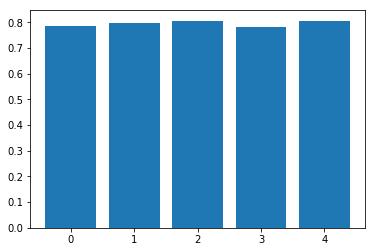

In [7]:
CV(pipeADA, 5)

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


average 5-fold validation accuracy: 0.768508


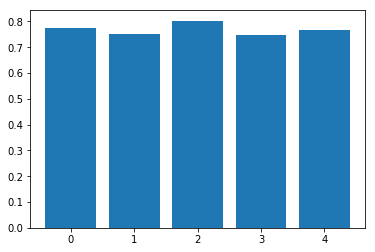

In [8]:
CV(pipeRF, 5)

As we see, AdaBoost gives a better result, so let's use it

### Fitting on full training set

In [10]:
model = pipeADA

model.fit(
    (trainData, trainImages),
    trainY,
    tr__all_langs=all_langs,
    tr__all_countries=all_countries,
    tr__all_ratings=all_ratings,
    tr__hist_bins=6
)
pass

### Predicting the output and saving results

In [ ]:
predictions = pd.DataFrame(model.predict_proba((testData, testImages))[:,1], index=testData.index, columns=['Probability'])

outfile = "daletski_denis_task_2_predictions.csv"
predictions.to_csv(outfile)

## Conclusion and outline

Another model I tried to use her was a milti-input CNN. First it took posters, then after convolution layers there was another input for other movies data. All this data + output of convolution layers then passed through dense layes. So this network used spatial features of posters plus other movies data. But there are not enough training data to train CNN and get a satisfactory accuracy